In [192]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
from scipy.stats import norm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils
from matplotlib import colors
from settings import colors as nc_colors

In [161]:
mplego.style.use_latex_style()
ccycle = mplego.colors.get_default_ccycle()

In [162]:
base_path = "/storage/noise_correlations/exp10"

In [163]:
pvc11_1_path = os.path.join(base_path, 'exp10_1_pvc11_20_1000_1000.h5')
ret2_path = os.path.join(base_path, 'exp10_ret2_20_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp10_ecog_20_3000_1000.h5')

In [164]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
#pvc11_2 = h5py.File(pvc11_2_path, 'r')
#pvc11_3 = h5py.File(pvc11_3_path, 'r')
#ret2 = h5py.File(ret2_path, 'r')
#ecog = h5py.File(ecog_path, 'r')
#results = [pvc11_1, pvc11_2, pvc11_3, ret2, ecog]
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
idxs = np.argsort(pvc11_1['p_r_lfi'][0])[:20]

In [211]:
def plot_marginals(mu, cov, lim, pcts, ax, compare=True, denom=.18):
    marginal_pdf0 = norm(loc=mu[0], scale=np.sqrt(cov[0, 0]))
    marginal_pdf1 = norm(loc=mu[1], scale=np.sqrt(cov[1, 1]))
    v0 = marginal_pdf0.cdf(pcts[0])
    v1 = marginal_pdf1.cdf(pcts[1])
    xs = np.linspace(lim[0], lim[1], 4800)
    idxs = xs < pcts[0]
    ys0 = marginal_pdf0.pdf(xs)
    ys1 = marginal_pdf1.pdf(xs)
    ax.plot(xs, -ys0 * lim[0] / denom + lim[0], c='k')
    c = 'gray'
    if compare:
        if v0 > v1:
            ax.text(-4.5, -7, r'$\textbf{END}$', size=20, ha='center', va='center')
            c = 'dimgray'
        else:
            ax.text(-6, -2.5, r'$\textbf{END}$', size=20, ha='center', va='center')
            c = 'lightgray'
    ax.fill_between(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys0[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)
    idxs = xs < pcts[1]
    ys = marginal_pdf1.pdf(xs)
    ax.plot(-ys1 * lim[0] / denom + lim[0], xs,c='k')
    if compare:
        if v0 > v1:
            c = 'lightgray'
        else:
            c = 'dimgray'
    ax.fill_betweenx(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys1[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)

def plot_fano(mu, cov, ax, label=True):
    ax.errorbar(23, mu[1],
                yerr=[np.sqrt(cov[1, 1])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)
    ax.text(24, mu[1], r'\boldmath$\sigma_2$', size=20)
    ax.text(mu[0] - 5 - np.sqrt(cov[0, 0]), 24, r'\boldmath$\sigma_1$', size=20)
    ax.errorbar(mu[0], 23,
                xerr=[np.sqrt(cov[0, 0])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)

def plot_corr(mu, cov, ax):
    w, v = np.linalg.eigh(utils.cov2corr(cov))
    ax.text(24, mu[1], r'\boldmath$\sigma_2$', size=20)
    ax.text(mu[0] - 5 - np.sqrt(cov[0, 0]), 24, r'\boldmath$\sigma_1$', size=20)
    ax.errorbar(23, mu[1],
                yerr=[np.sqrt(cov[1, 1])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)
    ax.errorbar(mu[0], 23,
                xerr=[np.sqrt(cov[0, 0])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)

uniform p: 0.001
fa p: 0.0


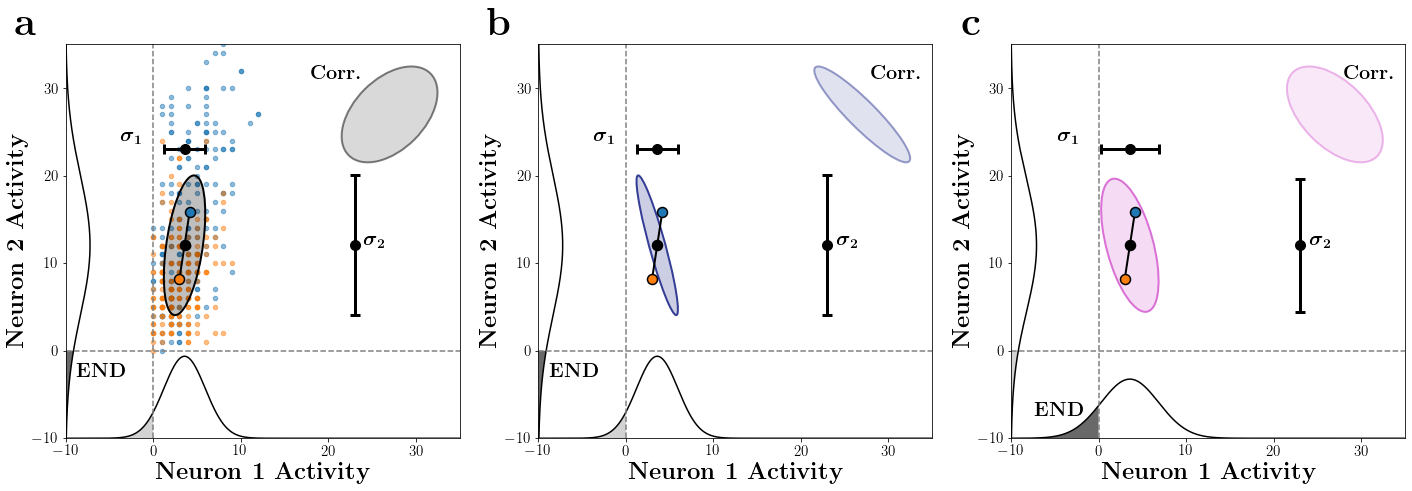

In [323]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
idx = idxs[8]
units = pvc11_1['units'][0, idx][:2]
Xu = pvc11_1['X'][:][:, units]
pcts = np.percentile(Xu, 1, axis=0)
opt = pvc11_1['opt_covs/3'][idx]
opt_fa = pvc11_1['opt_fa_covs/3'][idx]
opt_u = pvc11_1['opt_u_covs/3'][idx]
print('uniform p:', pvc11_1['p_u_lfi'][0, idx])
print('fa p:', pvc11_1['p_fa_lfi'][0, idx])
X1, X2 = utils.get_dimstim_responses_from_h5(pvc11_1, 0, idx)
cov1 = np.cov(X1.T)
cov2 = np.cov(X2.T)
obs = 0.5 * (cov1 + cov2)
mu1 = np.mean(X1, axis=0)
mu2 = np.mean(X2, axis=0)
avg_mean = 0.5 * (mu1 + mu2)

neuron1 = 0
neuron2 = 1
slc = [neuron1, neuron2]
lim = [-10, 35]

ax = axes[0]
# Plot the neural responses, stimulus 1
ax.scatter(
    X1[:, neuron1], X1[:, neuron2],
    marker='o',
    color='C0',
    alpha=0.5,
    s=20)


# Plot the neural responses, stimulus 2
ax.scatter(
    X2[:, neuron1], X2[:, neuron2],
    marker='o',
    color='C1',
    alpha=0.5,
    s=20)


# Plot observed covariance ellipse
plot_cov_ellipse(
    obs[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb('#000000', 0.25),
    edgecolor=mplego.colors.hex_to_rgb('#000000', 1.0))
plot_marginals(avg_mean[[neuron1, neuron2]],
               obs[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax)
plot_fano(avg_mean[[neuron1, neuron2]],
               obs[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)
plot_cov_ellipse(
    utils.cov2corr(obs[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb('#000000', 0.15),
    edgecolor=mplego.colors.hex_to_rgb('#000000', .5))


ax = axes[2]
# Plot optimal FA covariance ellipse
plot_cov_ellipse(
    opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=colors.to_rgba(nc_colors['fa'], 0.25),
    edgecolor=colors.to_rgba(nc_colors['fa'], 1.0))
plot_cov_ellipse(
    utils.cov2corr(opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=colors.to_rgba(nc_colors['fa'], 0.15),
    edgecolor=colors.to_rgba(nc_colors['fa'], .5))
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)
plot_fano(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)



ax = axes[1]
# Plot optimal uniform covariance ellipse
plot_cov_ellipse(
    opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 0.25),
    edgecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 1.0))
plot_cov_ellipse(
    utils.cov2corr(opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=colors.to_rgba(nc_colors['uniform'], 0.15),
    edgecolor=colors.to_rgba(nc_colors['uniform'], .5))
plot_corr(avg_mean[[neuron1, neuron2]],
               opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)


axes[0].text(18, 31, r'$\textbf{Corr.}$', size=20)
axes[1].text(28, 31, r'$\textbf{Corr.}$', size=20)
axes[2].text(28, 31, r'$\textbf{Corr.}$', size=20)
labels = ['a', 'b', 'c']
for ii, ax in enumerate(axes.ravel()):
    # Plot the differential correlation direction
    ax.plot(
        [mu1[neuron1], mu2[neuron1]], [mu1[neuron2], mu2[neuron2]],
        linewidth=2,
        color='black')
    # Plot the mean, stimulus 1
    ax.scatter(
        mu1[neuron1], mu1[neuron2],
        color='C0',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Plot the mean, stimulus 2
    ax.scatter(
        mu2[neuron1], mu2[neuron2],
        color='C1',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Plot the average mean
    ax.scatter(
        avg_mean[neuron1], avg_mean[neuron2],
        color='black',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Indicate the axes
    ax.axvline(0, linestyle='--', color='gray')
    ax.axhline(0, linestyle='--', color='gray')

    mplego.scatter.tighten_scatter_plot(ax, lim=lim, identity=False)

    ax.set_xlabel(r'$\textbf{Neuron 1 Activity}$', fontsize=24)
    ax.set_ylabel(r'$\textbf{Neuron 2 Activity}$', fontsize=24)
    ax.set_xticks([-10, 0, 10, 20, 30])
    ax.set_yticks([-10, 0, 10, 20, 30])
    ax.tick_params(labelsize=15)
mplego.labels.apply_subplot_labels(axes.ravel(), x=-0.1, size=40, bold=True)
plt.savefig('figure4.jpg', bbox_inches='tight')
plt.savefig('figure4.pdf', bbox_inches='tight')

In [225]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ret2 = h5py.File(ret2_path, 'r')
ecog = h5py.File(ecog_path, 'r')

In [324]:
median_corrs = dict()
median_corrs_fa = dict()
median_corrs_u = dict()

pct = 50

for d in [3, 5, 10, 20]:
    indices = np.triu_indices(d, k=1)
    median_corrs[d] = []
    for ii in range(12000):
        X1, X2 = utils.get_dimstim_responses_from_h5(pvc11_1, d - 3, ii)
        cov1 = np.cov(X1.T)
        cov2 = np.cov(X2.T)
        obs = utils.cov2corr(0.5 * (cov1 + cov2))
        median_corrs[d].append(np.percentile(abs(obs[indices[0], indices[1]]), pct,
                                             interpolation='nearest'))

    opt_fa = pvc11_1['opt_fa_covs/{}'.format(d)][:]
    diag = opt_fa[:, np.arange(d), np.arange(d)]
    opt_fa = opt_fa / np.sqrt(diag[..., np.newaxis] * diag[:, np.newaxis])
    median_corrs_fa[d] = np.percentile(abs(opt_fa[:, indices[0], indices[1]]), pct,
                                       axis=1, interpolation='nearest')

    opt_u = pvc11_1['opt_u_covs/{}'.format(d)][:]
    diag = opt_u[:, np.arange(d), np.arange(d)]
    opt_u = opt_u / np.sqrt(diag[..., np.newaxis] * diag[:, np.newaxis])
    median_corrs_u[d] = np.percentile(abs(opt_u[:, indices[0], indices[1]]), pct,
                                      axis=1, interpolation='nearest')

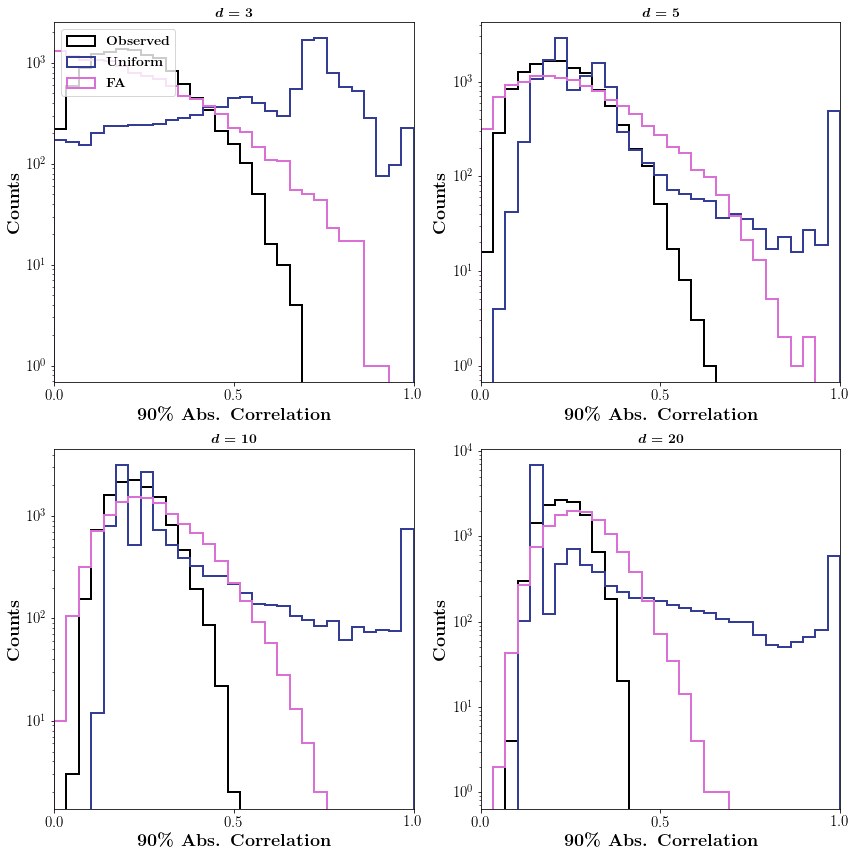

In [325]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

bins = np.linspace(0, 1, 30)

for ii, d in enumerate([3, 5, 10, 20]):
    ax = axes.ravel()[ii]
    label = r'\textbf{Observed}'
    label_u = r'\textbf{Uniform}'
    label_fa = r'\textbf{FA}'
    if ii != 0:
        label = None
        label_u = None
        label_fa = None
    ax.hist(median_corrs[d], bins=bins, histtype='step', ec=nc_colors['observed'],
            lw=2, label=label)
    ax.hist(median_corrs_u[d], bins=bins, histtype='step', ec=nc_colors['uniform'],
            lw=2, label=label_u)
    ax.hist(median_corrs_fa[d], bins=bins, histtype='step', ec=nc_colors['fa'],
            lw=2, label=label_fa)
    ax.set_yscale('log')
    ax.set_xlabel(r'\textbf{90\% Abs. Correlation}', size=18)
    ax.set_ylabel(r'\textbf{Counts}', size=18)
    ax.set_xticks([0, .5, 1])
    ax.set_xlim(0, 1)
    ax.tick_params(labelsize=15)
    ax.set_title(r'\boldmath$d={}$'.format(d), size=14)
axes[0, 0].legend(loc='upper left', fontsize=14)
fig.tight_layout()